In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm.notebook import tqdm
import os
import zipfile
import timm
import torchinfo
import models

In [91]:
def is_football(x, model, preprocess, threshold=0.2):
    m, _, _, _= model(x)
    m = m.detach().numpy()
    diff = np.abs(x - m) 
    if diff.all() > threshold:
        return True
    return False

def is_event(model, preprocess, x):
    x = x.view(-1, 3, 224, 224)
    _, pred = torch.max(model(x), 1)
    # print(f"is_event: {pred}")
    if pred == 1:
        return False
    return True


def event_detection(model, preprocess, x):
    # x = preprocess(x)
    x = x.view(-1, 3, 224, 224)
    outputs = model(x)
    last_hidden_states = outputs.last_hidden_state
    cls_embeddings = last_hidden_states[:, 0, :]
    logits = model.Classifier(cls_embeddings)
    logits = torch.argmax(logits, dim=1)
    return logits

def card(model, preprocess, x):
    # x = preprocess(x)
    x = x.view(-1, 3, 224, 224)
    outputs = model(x)
    return torch.argmax(outputs, dim=1)

In [92]:
# Load data
data_vae = datasets.ImageFolder(root='./trial', transform=models.vqvae_transform)
data_gen = datasets.ImageFolder(root='./trial', transform=models.nfnet_transform)

In [93]:
dir_class_to_idx = data_vae.class_to_idx
dir_idx_to_class = {v: k for k, v in dir_class_to_idx.items()}
dir_idx_to_class[1] = 'No Event'
dir_idx_to_class[5] = 'No Event'
dir_idx_to_class[8] = 'No Event'


dir_idx_to_class

{0: 'Cards',
 1: 'No Event',
 2: 'Corner',
 3: 'Event',
 4: 'Free-Kick',
 5: 'No Event',
 6: 'Penalty',
 7: 'Red-Cards',
 8: 'No Event',
 9: 'Soccer',
 10: 'Tackle',
 11: 'To_Subtitue',
 12: 'Yellow-Cards'}

In [94]:
event_class = {'Cards':0, 'Corner':0, 'Event':0, 'Free-Kick':0, 'Penalty':0, 'Red-Cards':0, 'Tackle':0, 'To_Subtitue':0, 'Yellow-Cards':0, 'Center':1, 'Left':1, 'Right':1, 'Soccer':1}

In [95]:
num_event_class = {'Cards':0, 'Corner':1, 'Free-Kick':2, 'Penalty':3, 'Tackle':4, 'To_Subtitue':5}
num_event_class_inv = {0:'Cards', 1:'Corner', 2:'Free-Kick', 3:'Penalty', 4:'Tackle', 5:'To_Subtitue'}

In [96]:
indices = torch.randperm(len(data_vae)).tolist()
data_vae = torch.utils.data.Subset(data_vae, indices)
data_gen = torch.utils.data.Subset(data_gen, indices)

# Loader
loader_vae = torch.utils.data.DataLoader(data_vae, batch_size=1, shuffle=False)
loader_gen = torch.utils.data.DataLoader(data_gen, batch_size=1, shuffle=False)

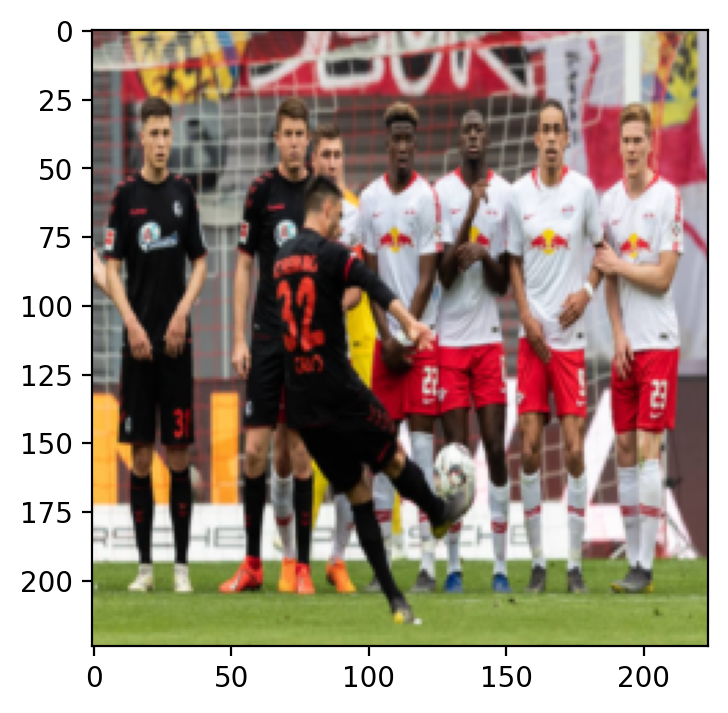

Event
5
To_Subtitue
real class Free-Kick


In [97]:
for i, (x, y) in enumerate(loader_vae):
    # print(x)
    # print(y[0].item())
    plt.figure(figsize=(4, 4))
    plt.imshow(data_gen[i][0].permute(1,2,0))
    plt.show()
    # print(dir_idx_to_class[y[0].item()])
    # break
    if is_football(x, models.vqvae, models.vqvae_transform):
        if is_event(models.nfnet, models.nfnet_transform, data_gen[i][0]): # Event
            print('Event')
            out = event_detection(models.vit, models.processor, data_gen[i][0]).item()
            print(out)
            print(num_event_class_inv[out])
            if num_event_class_inv[out] == 'Cards':
                print(card(models.nfnet, models.nfnet_transform, data_gen[i][0]))
        else: 
            print('No event')
    else:
        print('Not football')
    
    real_class = dir_idx_to_class[y[0].item()]
    print(f'real class {real_class}')
    break


In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Initialize lists to store the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the dataset
for i, (x, y) in tqdm(enumerate(loader_vae)):
    # Print image and real class
    # plt.figure(figsize=(4, 4))
    # plt.imshow(data_gen[i][0].permute(1, 2, 0))
    # plt.show()
    real_class = dir_idx_to_class[y[0].item()]
    # print(f"Real class: {real_class}")
    
    # Check if it is football
    if is_football(x, models.vqvae, models.vqvae_transform):
        # Check if it is an event
        if is_event(models.nfnet, models.nfnet_transform, data_gen[i][0]):
            # print("Event")
            out = event_detection(models.vit, models.processor, data_gen[i][0]).item()
            predicted_label = num_event_class_inv[out]
            # print(f"Predicted class: {predicted_label}")
            
            # Calculate evaluation metrics
            true_labels.append(real_class)
            predicted_labels.append(predicted_label)
            
            # Perform additional action for 'Cards' class
            if predicted_label == "Cards":
                predicted_label = card(models.FG, models.FG_transform, data_gen[i][0])
        else:
            # print("No event")
            predicted_label = "No event"
            # print(f"Predicted class: {predicted_label}")
            
            # Calculate evaluation metrics
            true_labels.append(real_class)
            predicted_labels.append(predicted_label)
    else:
        # print("Not football")
        predicted_label = "Not football"
        # print(f"Predicted class: {predicted_label}")
        
        # Calculate evaluation metrics
        true_labels.append(real_class)
        predicted_labels.append(predicted_label)
    
    if i == 1500:
        break

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="weighted")
recall = recall_score(true_labels, predicted_labels, average="weighted")
f1 = f1_score(true_labels, predicted_labels, average="weighted")

# Print evaluation metrics
# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")

0it [00:00, ?it/s]

/Users/jadyehya/opt/anaconda3/envs/Anaconda_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jadyehya/opt/anaconda3/envs/Anaconda_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.28181212524983346
Precision: 0.2711425735424686
Recall: 0.28181212524983346
F1 Score: 0.24312619825364146
